In [96]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2 as cv
from sklearn.cluster import MiniBatchKMeans
from skimage.feature import hog
from skimage import exposure

# Load data

In [97]:
# File data
csv1 = '../data/fer_data.csv'
csv2 = '../data/pca/fer_pca_inverse.csv'
df = pd.read_csv(csv1)
df_pca = pd.read_csv(csv2)

In [98]:
df.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39328 entries, 0 to 39327
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   usage    39328 non-null  object
 1   emotion  39328 non-null  int64 
 2   pixels   39328 non-null  object
dtypes: int64(1), object(2)
memory usage: 921.9+ KB


In [86]:
df_pca.head()

,usage,emotion,pca
0,train,3,103 107 99 91 90 94 100 103 103 103 103 107 11...
1,train,3,147 149 148 148 149 152 153 152 151 150 150 14...
2,train,3,107 119 134 152 173 186 193 196 196 198 198 20...
3,train,3,146 145 133 122 116 123 141 165 186 201 208 20...
4,train,3,220 202 169 130 98 91 105 133 159 175 186 185 ...


In [87]:
df_pca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39328 entries, 0 to 39327
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   usage    39328 non-null  object
 1   emotion  39328 non-null  int64 
 2   pca      39328 non-null  object
dtypes: int64(1), object(2)
memory usage: 921.9+ KB


# Local Feature/Binary Descriptors

In [7]:
# Local feature descriptors 
def sift():
    sift = cv.SIFT_create()
    return sift

def kaze():
    kaze = cv.KAZE_create()
    return kaze

# Local binary descriptors
def orb():
    orb = cv.ORB_create(nfeatures = 50,
                        scaleFactor = 1.2,
                        nlevels = 2,
                        edgeThreshold = 2,
                        firstLevel = 0,
                        scoreType = 0,
                        patchSize = 2)
    return orb

def brisk():
    brisk = cv.BRISK_create()
    return brisk

    
def akaze():
    akaze = cv.AKAZE_create()
    return akaze

## Display keypoint of each detectors

In [8]:
def displayKeypoints(file, featureDetector, detectorLabel):
    img = cv.imread(file)
    if detectorLabel == 'BRISK':
        img = cv.resize(img, (100, 100))
    elif detectorLabel == 'AKAZE':
        img = cv.resize(img, (200, 200))
    gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    kp = featureDetector.detect(gray,None)
    img=cv.drawKeypoints(gray,kp,img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(detectorLabel)

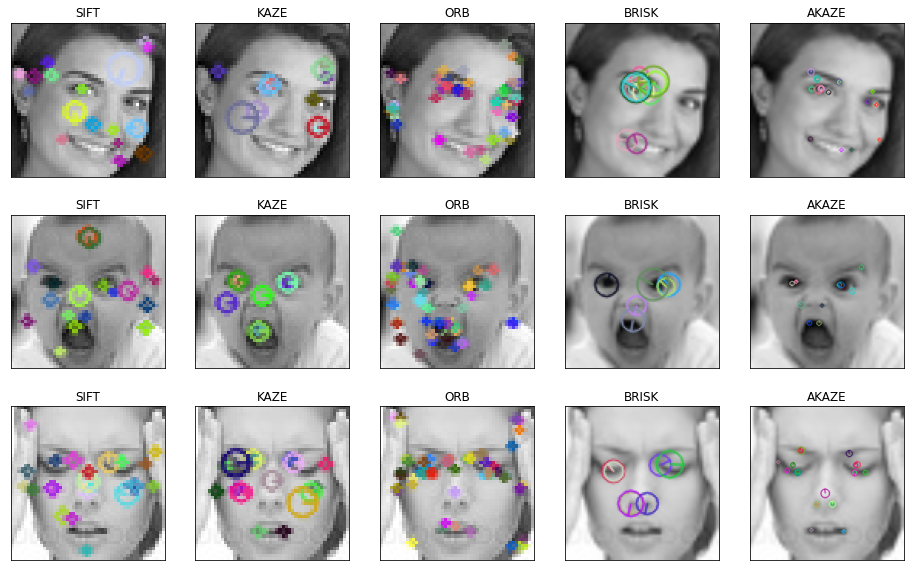

In [9]:
files = ['../data/external/fer2013/train/happy/Training_87867.jpg',
        '../data/external/fer2013/train/angry/Training_143373.jpg',
        '../data/external/fer2013/train/sad/Training_6293881.jpg']
titles = {0:'SIFT', 1:'KAZE', 2:'ORB', 3:'BRISK', 4:'AKAZE'}

plt.figure(figsize=(16,10))
i = 0
for file in files: 
    j = i * 5
    plt.subplot(3, 5, j+1)
    displayKeypoints(file, sift(), 'SIFT')
    plt.subplot(3, 5, j+2)
    displayKeypoints(file, kaze(), 'KAZE')
    plt.subplot(3, 5, j+3)
    displayKeypoints(file, orb(), 'ORB')
    plt.subplot(3, 5, j+4)
    displayKeypoints(file, brisk(), 'BRISK')
    plt.subplot(3, 5, j+5)
    displayKeypoints(file, akaze(), 'AKAZE')
    i += 1


## Extract Features descriptors and apply KMeans and Histograms

In [88]:
def getDescriptors(image, featureDetector, detectorLabel):
#     image = cv.imread(file)
#     gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    image = image.reshape(48,48).astype('uint8')
    if detectorLabel == 'BRISK':
        image = cv.resize(image, (100, 100))
    elif detectorLabel == 'AKAZE':
        image = cv.resize(image, (200, 200))
    keypoints, descriptors = featureDetector.detectAndCompute(image,None)
    return keypoints, descriptors


def extractFeatures(df, featureDetector, detectorLabel, pca):
    descriptors = []
    emotions = []
    for index, row in df.iterrows():
        if pca == True:
            image = np.fromstring(row.pca, dtype=int, sep=' ')
        else:
            image = np.fromstring(row.pixels, dtype=int, sep=' ')
        kp, desc = getDescriptors(image, featureDetector, detectorLabel)
        if type(desc) != type(None):
            descriptors.append(desc)
            emotions.append(row.emotion)
            
    return descriptors, emotions


def flatFeatures(descriptors):
    all_descriptors = []
    for i in range(len(descriptors)):
        all_descriptors.extend(descriptors[i])
            
    return all_descriptors
        
        
def kMeans(k, all_descriptors):
    batch_size = int(len(all_descriptors) / 3) 
    kmeans = MiniBatchKMeans(n_clusters = k,
                             batch_size = batch_size,
                             init_size = None)
    kmeans.fit(all_descriptors)
    
    return kmeans
        
        
def histograms(k, all_descriptors, descriptors):
    histograms = []
    kmeans = kMeans(k, all_descriptors)
    
    for i in range(len(descriptors)):
        preds = kmeans.predict(descriptors[i].astype('float'))
        hist, bin_edges = np.histogram(a = preds, bins = range(0, k))
        histograms.append(hist)
    
    return histograms


def processFeatureExtraction(df, k, featureDetector, detectorLabel, pca):
    train_descriptors, train_emotions = extractFeatures(df[df['usage']=='train'], featureDetector, detectorLabel, pca)
    test_descriptors, test_emotions = extractFeatures(df[df['usage']=='test'], featureDetector, detectorLabel, pca)

    # Flatten data
    train_descriptors_flat = flatFeatures(train_descriptors)
    test_descriptors_flat = flatFeatures(test_descriptors)
    
    print("Descripter size: train "+ str(len(train_descriptors)) + " test "+ str(len(test_descriptors)))
    print("Emotion size: train "+ str(len(train_emotions)) + " test "+ str(len(test_emotions)))
    
    # Get Histogram data
    train_hist = histograms(k, train_descriptors_flat, train_descriptors)
    test_hist = histograms(k, test_descriptors_flat, test_descriptors)
    
    print("Train Histogram size: " + str(np.array(train_hist).shape))
    print("Test Histogram size: " + str(np.array(test_hist).shape))
#     print(train_hist[0])
    
    return train_hist, train_emotions, test_hist, test_emotions

## Save Bag of Feature data

In [81]:
def combineData(usage, values, emotions):
    feature_data = []
    for i in range(len(values)):
        vectors = ' '.join(str(x.astype('int')) for x in values[i])
        feature_data.append([usage, emotions[i], vectors])
    return feature_data

def saveBofData(file, X_train, y_train, X_test, y_test):
    train_data = combineData('train', X_train, y_train)
    test_data = combineData('test', X_test, y_test)
    data = train_data + test_data
    df = pd.DataFrame(data, columns = ['usage', 'emotion', 'histogram'])
    df.to_csv(file, index=False)
#     df.info()

## Create Feature Extraction data

In [90]:
# Set K values
k = [100, 500, 1000]

### SIFT

In [91]:
# Original data 
print('Original')
for i in range(len(k)):
    print('K: '+str(k[i]))
    X_train, y_train, X_test, y_test = processFeatureExtraction(df, k[i], sift(), 'SIFT', False)
    csv = '../data/sift/sift_bof_'+str(k[i])+'.csv'
    saveBofData(csv, X_train, y_train, X_test, y_test)

# PCA inverse data
print('Inverse PCA')
for i in range(len(k)):
    print('K: '+str(k[i]))
    X_train, y_train, X_test, y_test = processFeatureExtraction(df_pca, k[i], sift(), 'SIFT', True)
    csv = '../data/sift/sift_pca_bof_'+str(k[i])+'.csv'
    saveBofData(csv, X_train, y_train, X_test, y_test)

Original
K: 100
Descripter size: train 31427 test 7895
Emotion size: train 31427 test 7895
Train Histogram size: (31427, 99)
Test Histogram size: (7895, 99)
K: 500
Descripter size: train 31427 test 7895
Emotion size: train 31427 test 7895
Train Histogram size: (31427, 499)
Test Histogram size: (7895, 499)
K: 1000
Descripter size: train 31427 test 7895
Emotion size: train 31427 test 7895
Train Histogram size: (31427, 999)
Test Histogram size: (7895, 999)
Inverse PCA
K: 100
Descripter size: train 31425 test 7894
Emotion size: train 31425 test 7894
Train Histogram size: (31425, 99)
Test Histogram size: (7894, 99)
K: 500
Descripter size: train 31425 test 7894
Emotion size: train 31425 test 7894
Train Histogram size: (31425, 499)
Test Histogram size: (7894, 499)
K: 1000
Descripter size: train 31425 test 7894
Emotion size: train 31425 test 7894
Train Histogram size: (31425, 999)
Test Histogram size: (7894, 999)


### KAZE

In [92]:
# Original data 
print('Original')
for i in range(len(k)):
    print('K: '+str(k[i]))
    X_train, y_train, X_test, y_test = processFeatureExtraction(df, k[i], kaze(), 'KAZE', False)
    csv = '../data/kaze/kaze_bof_'+str(k[i])+'.csv'
    saveBofData(csv, X_train, y_train, X_test, y_test)

# PCA inverse data
print('Inverse PCA')
for i in range(len(k)):
    print('K: '+str(k[i]))
    X_train, y_train, X_test, y_test = processFeatureExtraction(df_pca, k[i], kaze(), 'KAZE', True)
    csv = '../data/kaze/kaze_pca_bof_'+str(k[i])+'.csv'
    saveBofData(csv, X_train, y_train, X_test, y_test)

Original
K: 100
Descripter size: train 31284 test 7856
Emotion size: train 31284 test 7856
Train Histogram size: (31284, 99)
Test Histogram size: (7856, 99)
K: 500
Descripter size: train 31284 test 7856
Emotion size: train 31284 test 7856
Train Histogram size: (31284, 499)
Test Histogram size: (7856, 499)
K: 1000
Descripter size: train 31284 test 7856
Emotion size: train 31284 test 7856
Train Histogram size: (31284, 999)
Test Histogram size: (7856, 999)
Inverse PCA
K: 100
Descripter size: train 31275 test 7853
Emotion size: train 31275 test 7853
Train Histogram size: (31275, 99)
Test Histogram size: (7853, 99)
K: 500
Descripter size: train 31275 test 7853
Emotion size: train 31275 test 7853
Train Histogram size: (31275, 499)
Test Histogram size: (7853, 499)
K: 1000
Descripter size: train 31275 test 7853
Emotion size: train 31275 test 7853
Train Histogram size: (31275, 999)
Test Histogram size: (7853, 999)


### ORB

In [93]:
# Original data 
print('Original')
for i in range(len(k)):
    print('K: '+str(k[i]))
    X_train, y_train, X_test, y_test = processFeatureExtraction(df, k[i], orb(), 'ORB', False)
    csv = '../data/orb/orb_bof_'+str(k[i])+'.csv'
    saveBofData(csv, X_train, y_train, X_test, y_test)

# PCA inverse data
print('Inverse PCA')
for i in range(len(k)):
    print('K: '+str(k[i]))
    X_train, y_train, X_test, y_test = processFeatureExtraction(df_pca, k[i], orb(), 'ORB', True)
    csv = '../data/orb/orb_pca_bof_'+str(k[i])+'.csv'
    saveBofData(csv, X_train, y_train, X_test, y_test)

Original
K: 100
Descripter size: train 31430 test 7896
Emotion size: train 31430 test 7896
Train Histogram size: (31430, 99)
Test Histogram size: (7896, 99)
K: 500
Descripter size: train 31430 test 7896
Emotion size: train 31430 test 7896
Train Histogram size: (31430, 499)
Test Histogram size: (7896, 499)
K: 1000
Descripter size: train 31430 test 7896
Emotion size: train 31430 test 7896
Train Histogram size: (31430, 999)
Test Histogram size: (7896, 999)
Inverse PCA
K: 100
Descripter size: train 31400 test 7890
Emotion size: train 31400 test 7890
Train Histogram size: (31400, 99)
Test Histogram size: (7890, 99)
K: 500
Descripter size: train 31400 test 7890
Emotion size: train 31400 test 7890
Train Histogram size: (31400, 499)
Test Histogram size: (7890, 499)
K: 1000
Descripter size: train 31400 test 7890
Emotion size: train 31400 test 7890
Train Histogram size: (31400, 999)
Test Histogram size: (7890, 999)


### BRISK

In [94]:
# Original data 
print('Original')
for i in range(len(k)):
    print('K: '+str(k[i]))
    X_train, y_train, X_test, y_test = processFeatureExtraction(df, k[i], brisk(), 'BRISK', False)
    csv = '../data/brisk/brisk_bof_'+str(k[i])+'.csv'
    saveBofData(csv, X_train, y_train, X_test, y_test)

# PCA inverse data
print('Inverse PCA')
for i in range(len(k)):
    print('K: '+str(k[i]))
    X_train, y_train, X_test, y_test = processFeatureExtraction(df_pca, k[i], brisk(), 'BRISK', True)
    csv = '../data/brisk/brisk_pca_bof_'+str(k[i])+'.csv'
    saveBofData(csv, X_train, y_train, X_test, y_test)

Original
K: 100
Descripter size: train 30833 test 7731
Emotion size: train 30833 test 7731
Train Histogram size: (30833, 99)
Test Histogram size: (7731, 99)
K: 500
Descripter size: train 30833 test 7731
Emotion size: train 30833 test 7731
Train Histogram size: (30833, 499)
Test Histogram size: (7731, 499)
K: 1000
Descripter size: train 30833 test 7731
Emotion size: train 30833 test 7731
Train Histogram size: (30833, 999)
Test Histogram size: (7731, 999)
Inverse PCA
K: 100
Descripter size: train 8004 test 2160
Emotion size: train 8004 test 2160
Train Histogram size: (8004, 99)
Test Histogram size: (2160, 99)
K: 500
Descripter size: train 8004 test 2160
Emotion size: train 8004 test 2160
Train Histogram size: (8004, 499)
Test Histogram size: (2160, 499)
K: 1000
Descripter size: train 8004 test 2160
Emotion size: train 8004 test 2160
Train Histogram size: (8004, 999)
Test Histogram size: (2160, 999)


### AKAZE

In [95]:
# Original data 
print('Original')
for i in range(len(k)):
    print('K: '+str(k[i]))
    X_train, y_train, X_test, y_test = processFeatureExtraction(df, k[i], akaze(), 'AKAZE', False)
    csv = '../data/akaze/akaze_bof_'+str(k[i])+'.csv'
    saveBofData(csv, X_train, y_train, X_test, y_test)

# PCA inverse data
print('Inverse PCA')
for i in range(len(k)):
    print('K: '+str(k[i]))
    X_train, y_train, X_test, y_test = processFeatureExtraction(df_pca, k[i], akaze(), 'AKAZE', True)
    csv = '../data/akaze/akaze_pca_bof_'+str(k[i])+'.csv'
    saveBofData(csv, X_train, y_train, X_test, y_test)

Original
K: 100
Descripter size: train 31332 test 7862
Emotion size: train 31332 test 7862
Train Histogram size: (31332, 99)
Test Histogram size: (7862, 99)
K: 500
Descripter size: train 31332 test 7862
Emotion size: train 31332 test 7862
Train Histogram size: (31332, 499)
Test Histogram size: (7862, 499)
K: 1000
Descripter size: train 31332 test 7862
Emotion size: train 31332 test 7862
Train Histogram size: (31332, 999)
Test Histogram size: (7862, 999)
Inverse PCA
K: 100
Descripter size: train 25314 test 6606
Emotion size: train 25314 test 6606
Train Histogram size: (25314, 99)
Test Histogram size: (6606, 99)
K: 500
Descripter size: train 25314 test 6606
Emotion size: train 25314 test 6606
Train Histogram size: (25314, 499)
Test Histogram size: (6606, 499)
K: 1000
Descripter size: train 25314 test 6606
Emotion size: train 25314 test 6606
Train Histogram size: (25314, 999)
Test Histogram size: (6606, 999)


# HoG

In [100]:
def load_data(df):
    image_data = []
    
    for index, row in df.iterrows():
        image = np.fromstring(row.pixels, dtype=int, sep=' ')
        image_data.append(image)
        
    return image_data

In [101]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data = load_data(df_train)
train_target = list(df_train.emotion)
test_data = load_data(df_test)
test_target = list(df_test.emotion)

In [137]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [119]:
X_train.shape

(31432, 2304)

## Display one of picture with HoG

In [103]:
gray = X_train[0].reshape(48,48).astype('uint8')
image = cv.cvtColor(gray, cv.COLOR_GRAY2RGB)
image.shape

(48, 48, 3)

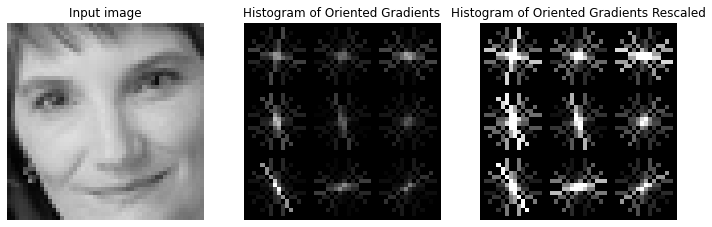

In [126]:
# Display
fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')

ax3.axis('off')
ax3.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax3.set_title('Histogram of Oriented Gradients Rescaled')

plt.show()

## Create HoG for all pictures

In [142]:
def getHoG(X):
    hog_data = []
    hog_scaled = []
    
    for i in range(len(X)):
        gray = X[i].reshape(48,48).astype('uint8')
        image = cv.cvtColor(gray, cv.COLOR_GRAY2RGB)
        image.shape

        fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                            cells_per_block=(1, 1), visualize=True, channel_axis=-1)

        # Rescale histogram for better display
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        
        hog_data.append(hog_image.flatten())
        hog_scaled.append(hog_image_rescaled.flatten())
        
    return hog_data, hog_scaled

In [150]:
train_data, train_scaled = getHoG(X_train)
test_data, test_scaled = getHoG(X_test)

In [151]:
X_train = np.array(train_data)
X_test = np.array(test_data)
X_train_scaled = np.array(train_scaled)
X_test_scaled = np.array(test_scaled)

In [152]:
print(X_train.shape)
print(X_test.shape)
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(31432, 2304)
(7896, 2304)
(31432, 2304)
(7896, 2304)


## Save HoG data

In [154]:
def saveHoGData(file, X_train, y_train, X_test, y_test):
    train_data = combineData('train', X_train, y_train)
    test_data = combineData('test', X_test, y_test)
    data = train_data + test_data
    df = pd.DataFrame(data, columns = ['usage', 'emotion', 'hog'])
    df.to_csv(file, index=False)

In [156]:
csv1 = '../data/hog/hog_data.csv'
csv2 = '../data/hog/hog_scaled.csv'
saveHoGData(csv1, X_train, y_train, X_test, y_test)
saveHoGData(csv2, X_train_scaled, y_train, X_test_scaled, y_test)